# Modeling Generalized Additive Model

Generalized Additive Model can be used as a generic supervised learning method for solving regression problem and it has the benefits of 
- Flexibility: GAMs can model non-linear relationships and interactions between variables. They can handle a variety of data distributions and link functions, making them more flexible than linear regression models.

- Interpretability: Each feature in a GAM has its own smoothing function, which can be plotted and interpreted separately. This makes it easier to understand the relationship between each feature and the response variable.

- Robustness: GAMs are less sensitive to outliers than linear regression models. The smoothing functions in a GAM can fit the general trend in the data without being overly influenced by extreme values.

- Works well with limited data set

Few limitations of GAM are:
- Computational Complexity: Fitting a GAM involves solving a series of non-linear equations, which can be computationally intensive, especially for large datasets or models with many features.

- Overfitting: Because of their flexibility, GAMs can overfit the data if the smoothing parameters are not chosen carefully. Overfitting can lead to poor generalization performance on new data.

In this tutorial, we will explore how to use the `SklearnCompatibleLinearGAM` class, a scikit-learn compatible wrapper for the `LinearGAM model` from the `pyGAM` library. This class allows us to use `LinearGAM` models in a scikit-learn pipeline and take advantage of scikit-learn's utilities for model validation, hyperparameter tuning, and more.

![SklearnCompatibleLinearGAM UML](_images/_SklearnCompatibleLinearGAM.drawio.svg)

## Setup


In [1]:
import typing as tp
import logging
import sys

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Resolve path when used in a usecase project
import sys
from pathlib import Path

sys.path.insert(0, str(Path("../../").resolve()))


First check if `pygam` is installed and install it if not.

You can checks by running the following in your notebook cell.

```python
try: 
    import pygam
except:
    !{sys.executable} -m pip -q install "oai.modeling[pygam]"
```

Then, we set up and create some data.

We generate a toy data with non linear relationship using the ["Friedman #1" regression problem](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_friedman1.html#sklearn.datasets.make_friedman1). 

In [4]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_friedman1

N_SAMPLES = 50
N_FEATURES = 5
NOISE = 0.5
RANDOM_STATE = 18

model_features = [f"Feature_{i + 1}" for i in range(N_FEATURES)]
model_target = "Target"

X, y = make_friedman1(
    n_samples=N_SAMPLES, 
    n_features=N_FEATURES,
    noise=NOISE,
    random_state=RANDOM_STATE,
)
features_data = pd.DataFrame(X, columns=model_features)
target_vector = pd.DataFrame(y, columns=[model_target])

master_data = pd.concat([features_data, target_vector], axis=1)
master_data['Target'] = (master_data['Target'] - master_data['Target'].mean()) / master_data['Target'].std()
master_data.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Target
0,0.650374,0.505453,0.878601,0.181840,0.852233,0.465399
1,0.750136,0.666102,0.987895,0.256968,0.028306,0.540001
2,0.635719,0.847312,0.736175,0.020807,0.111603,-0.457612
3,0.297724,0.686970,0.861626,0.198634,0.657189,-0.098747
4,0.699656,0.352392,0.789961,0.814048,0.197421,0.496910


## Create `SklearnCompatibleLinearGAM`

The SklearnCompatibleLinearGAM class is a wrapper for the LinearGAM model from the pyGAM library. It includes fit, predict, partial_dependence, and summary methods, similar to those in LinearGAM. However, it also includes additional checks to ensure compatibility with scikit-learn. 

To initialize the SklearnCompatibleLinearGAM class, you simply create an instance of the class. You can optionally specify the `terms`, `max_iter`, and `tol` parameters. 

- `terms`:  it defaults oo 'auto', which means that the model will automatically determine the best terms to use based on the data.
- `max_iter` is the maximum number of iterations for the solver
- `tol` is the tolerance for stopping criteria.


In [5]:
from modeling import SklearnCompatibleLinearGAM
from pygam import s, f

gam_term = (
    s(0, n_splines=5) # spline functions with degree 5 for the first feature
    + s(1, n_splines=5) # spline functions with degree 5 for the second feature
    + s(2, n_splines=8) # spline functions with degree 8 for the third feature
    + s(3, n_splines=5) # spline functions with degree 5 for the fourth feature
    + s(4, n_splines=8) # spline functions with degree 8 for the fifth feature
)
    
gam = SklearnCompatibleLinearGAM(
    terms=gam_term, 
    max_iter=100, 
    tol=1e-4
)


The `terms` argument in the `SklearnCompatibleLinearGAM` class is used to specify the terms of the model. This argument is passed directly to the `LinearGAM` model from the `pyGAM` library.

The terms argument can take several forms:

- 'auto': This is the default setting. The model will automatically determine the best terms to use based on the data. However, we recommend users to specify a formula instead of using `auto` setting. 

- A string specifying a formula: You can specify a formula using a string, similar to the formula interface in R. For example, `terms = '0 + spline(x1) + spline(x2)'` specifies a model with no intercept and spline terms for x1 and x2.

Please refer to [pyGAM documentation](https://pygam.readthedocs.io) to better understand how to use `terms`. 

In [6]:
gam.fit(X, y)

SklearnCompatibleLinearGAM(terms=s(0) + s(1) + s(2) + s(3) + s(4))

## Generate model summary

You can also generate model summary. Here's the definitions of all the terms in the summary:
- **number of samples**: The number of samples used to fit the model.
- **Effective DoF**: The estimated degrees of freedom for the term. This is a measure of the complexity of the term. A higher degrees of freedom means a more complex term.
- **Log Likelihood**: The log-likelihood of the model, which is a measure of model fit.
- **AIC**: The Akaike Information Criterion for the model, which is a measure of model fit that takes into account model complexity.
- **Scale**: The estimated scale parameter for the model.
- **Pseudo R-Squared**: It is an alternative measure that provides a similar interpretation to the R-squared. It measures the improvement of the fitted model compared to a null model that only includes the intercept.
- **Feature Function**: The name of the term. For example, s(0) refers to a spline term for the first feature.
- **Rank**: the "rank" refers to the number of basis functions used to represent the spline.
- **p_values**: The p-value for a hypothesis test that the true coefficient is zero. A small p-value (typically less than 0.05) indicates strong evidence that the coefficient is different from zero.
- **Sig. Code**: The significance level of the p-value. The symbols ***, **, *, and . represent p-values less than 0.001, 0.01, 0.05, and 0.1, respectively.

In [7]:
gam.model_.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     11.5316
Link Function:                     IdentityLink Log Likelihood:                                   -94.9016
Number of Samples:                           50 AIC:                                              214.8663
                                                AICc:                                              224.166
                                                GCV:                                                3.7629
                                                Scale:                                              2.2424
                                                Pseudo R-Squared:                                   0.9359
Feature Function                  Lam

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



## Visualize partial dependence and smoothed feature
In these plots, the red line represents the partial dependence, which shows the effect of the feature on the predicted outcome after applying the smoothing function. The blue area represents the confidence intervals, which give an indication of the uncertainty of the partial dependence. By comparing the line and the area, you can see how the smoothing function affects the relationship between the feature and the target variable, and how certain the model is about this relationship. We also compared between raw data and smoothed values to describe how smoothing functions transform data. 

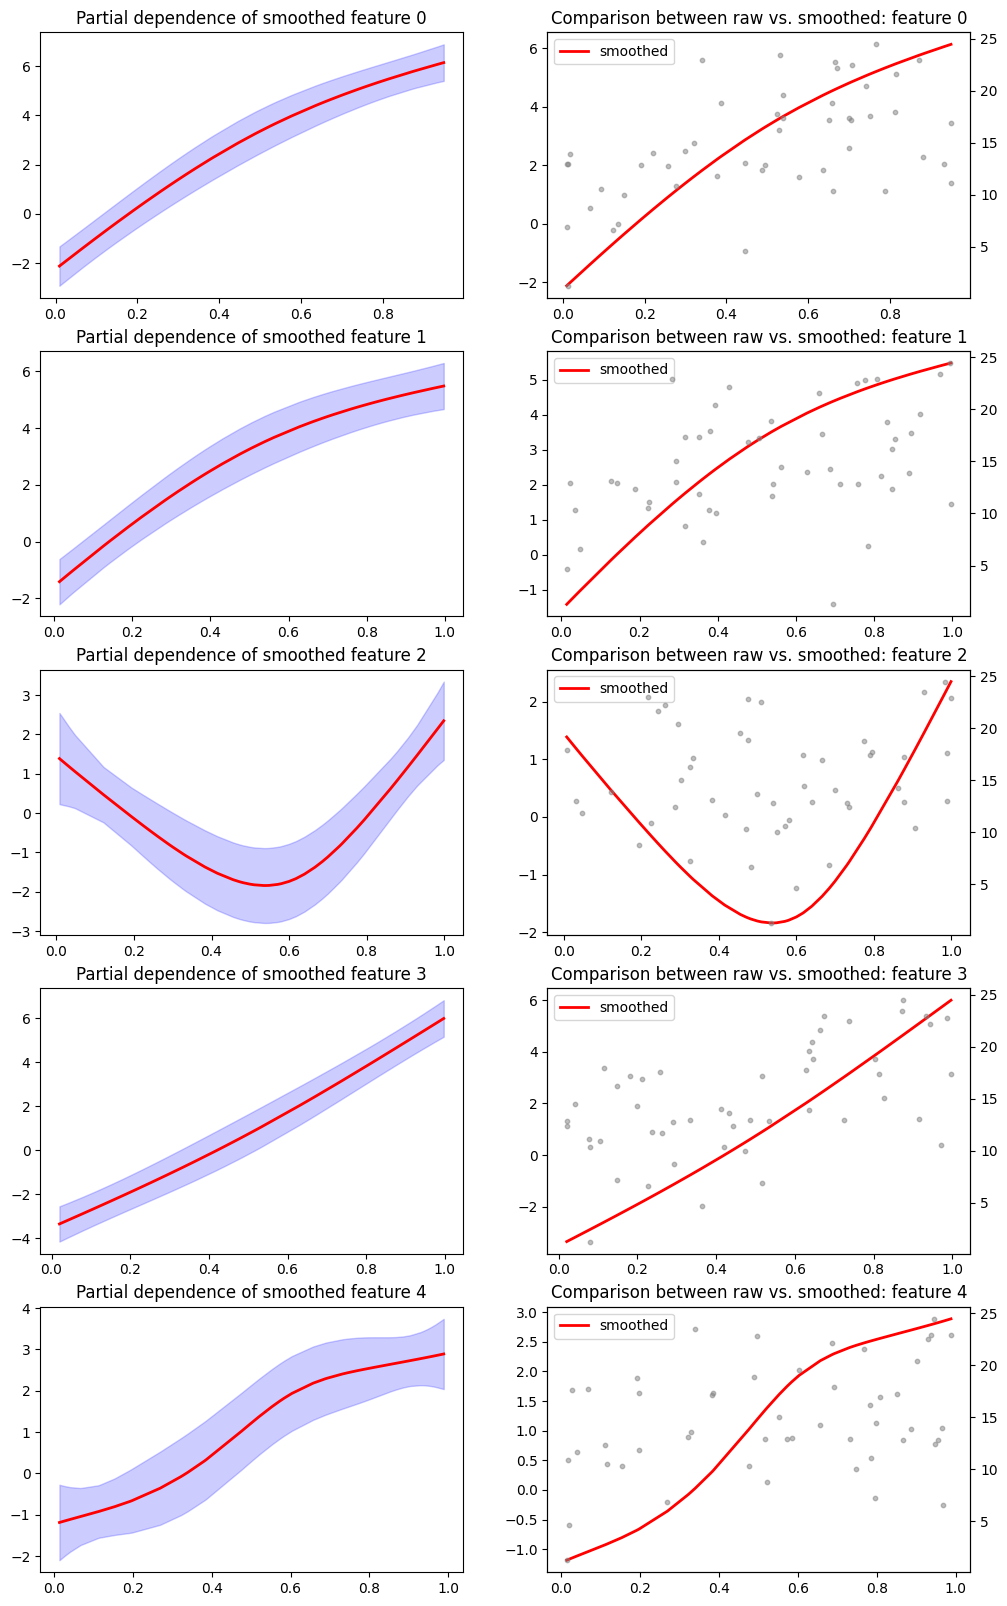

In [8]:
import matplotlib.pyplot as plt

n_features = X.shape[1]
fig, axs = plt.subplots(ncols=2, nrows=n_features, figsize=(12, 4 * n_features))

# For each feature
for i in range(n_features):
    # Compute the partial dependence
    partial_dependence, confidence_intervals = gam.partial_dependence(X, feature_idx=i, width=.95)

    # Plot the partial dependence
    axs[i][0].plot(
        np.sort(X[:, i]), 
        partial_dependence[np.argsort(X[:, i])],
        color='red',
        linewidth=2, 
        label='Partial dependence'
    )
        
    # Plot the confidence intervals
    axs[i][0].fill_between(
        np.sort(X[:, i]), 
        confidence_intervals[np.argsort(X[:, i])][:, 0], 
        confidence_intervals[np.argsort(X[:, i])][:, 1], 
        color='blue',
        alpha=.2
    )

    # plot comparison between raw data vs. smoothed
    
    twinx = axs[i][1].twinx()
    twinx.scatter(X[:, i], y, s=10, color='gray', alpha=0.5, label='Raw data')
    axs[i][1].plot(
        np.sort(X[:, i]), 
        partial_dependence[np.argsort(X[:, i])], 
        color='red', 
        linewidth=2, 
        label='smoothed'
    )
    axs[i][1].legend()

    # Add a title
    axs[i][0].set_title(f'Partial dependence of smoothed feature {i}')
    axs[i][1].set_title(f'Comparison between raw vs. smoothed: feature {i}')

    # Show the plot
plt.show()


Next we demostrate that we can still use the `train_model`, `calculate_model_predictions` and `calculate_metrics` from the `modelling` package. First, we train the model by using the first 30 samples of the data.

In [9]:
from modeling import train_model
from modeling import SklearnModelFactory
from modeling import calculate_model_predictions

In [10]:
# start with creating model_init_config
model_init_config = {
    "estimator": {
        "class_name": "modeling.SklearnCompatibleLinearGAM",
        "kwargs": {
            "terms": gam_term,
            "max_iter": 100,
            "tol": 1e-4,
        }
    }
}

Since it's sklearn-compatible class, we can use SklearnModelFactory from our modeling package

In [11]:

gam_factory = SklearnModelFactory(
    model_init_config=model_init_config, 
    features_in=model_features, 
    target=model_target,
)

model = gam_factory.create()

In [12]:
from modeling import train_model

train_data = master_data[:30]
model = train_model(model, train_data)

In [13]:
from modeling import calculate_model_predictions

test_data = master_data[30:]
predictions = calculate_model_predictions(
    test_data, model,
)

predictions.head()

,model_prediction
30,1.624686
31,0.409782
32,0.908557
33,2.837494
34,0.546692


In [14]:
from modeling import calculate_metrics

test_metrics = calculate_metrics(
    test_data, model=model,
)
test_metrics

{'mae': 0.253533447598855,
 'rmse': 0.34779912952124803,
 'mse': 0.12096423449573787,
 'mape': 0.53605039193848,
 'r_squared': 0.89001660526635,
 'var_score': 0.8908775589262835}